<a href="https://colab.research.google.com/github/ayaemad10/detect-and-predict-of-the-space-debris/blob/main/Prediction%20using%20a%20Machine%20Learning%20(LSTM)%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sgp4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 3.0 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow
import tensorflow as tf

# Instead of:
# from keras.utils.vis_utils import plot_model

# Use:
from tensorflow.keras.utils import plot_model

In [ ]:
from pandas import DataFrame

from matplotlib import pyplot
# import keras.utils.vis_utils # This line is no longer needed
from importlib import reload
# reload(keras.utils.vis_utils) # This line is no longer needed
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import autocorrelation_plot


from tensorflow.keras.utils import plot_model # Import plot_model from tensorflow.keras.utils
import sgp4
from sgp4.api import Satrec
from sgp4.api import SatrecArray
from sgp4.api import jday
from sgp4.api import days2mdhms
from sgp4.conveniences import sat_epoch_datetime
!pip install skyfield
import skyfield

from skyfield.sgp4lib import TEME_to_ITRF
from astropy import coordinates as coord
from astropy import units
from astropy.time import Time

import datetime

import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.2/336.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.6 MB/s eta 0:00:00


In [ ]:
# Commented out IPython magic to ensure Python compatibility.
# %matplotlib inline
#%matplotlib qt

"""# TLE Data"""

s = '1 54277U 22151U   24001.54504419  .00000346  00000+0  18937-3 0  9998'
t = '2 54277  98.8799  16.9842 0047491 242.8834 116.7492 14.17933773 58315'

satellite = Satrec.twoline2rv(s, t)
print("rasat")


rasat


In [ ]:
print(satellite.epochyr, satellite.epochdays)
#satellite.epochyr: This represents the year part of the epoch date.
#satellite.epochdays: This represents the fractional part of the year (days since the beginning of the year)
print(days2mdhms(satellite.epochyr, satellite.epochdays)) # Epoch date as month, day, hour, minute, seconds

sat_epoch_datetime(satellite) # Epoch date as month, day, hour, minute, seconds

24 1.54504419
(1, 1, 13, 4, 51.818016)


datetime.datetime(2024, 1, 1, 13, 4, 51, 818016, tzinfo=UTC)

In [ ]:
"""# Predict"""
# Predict Julian Date for the desired future date
jd, fr = jday(2024, 8, 1, 9, 0, 0)
print(jd, fr)

# Predict satellite Error code,position and velocity
e, r, v = satellite.sgp4(jd, fr)
print(e,r,v)



2460523.5 0.375
0 (-47.32893878620139, 1644.26179097908, 7020.901882720345) (4.874196251943108, 5.473237867682289, -1.2114735830581056)


In [ ]:
"""# Read TLE From txt"""

def satellite_from_txt(txt_dir):
    firsts = []
    seconds = []

    with open(txt_dir,"r") as openfileobject:
        for line in openfileobject:
            if(line[0] == '1'):
                firsts.append(line.strip())
            else:
                seconds.append(line.strip())

    satellites = []
    for first, second in zip(firsts, seconds):
        satellites.append(Satrec.twoline2rv(first, second))

    satellite_dict = {'Julian Date of Epoch':[],'First time derivative of the mean motion':[],
                      'Ballistic drag coefficient B* in inverse earth radii':[], 'Inclination':[], 'Right ascension of ascending node':[], 'Eccentricity':[], 'Argument of perigee':[], 'Mean anomaly':[], 'Mean motion':[]}

    for satellite in satellites:
        #satellite_dict['Epoch Years'].append(satellite.epochyr)
        #satellite_dict['Epoch Days'].append(satellite.epochdays)
        satellite_dict['Julian Date of Epoch'].append(satellite.jdsatepoch+satellite.jdsatepochF)
        satellite_dict['First time derivative of the mean motion'].append(satellite.ndot)
        #satellite_dict['Second time derivative of the mean motion'].append(satellite.nddot)
        satellite_dict['Ballistic drag coefficient B* in inverse earth radii'].append(satellite.bstar)
        satellite_dict['Eccentricity'].append(satellite.ecco)
        satellite_dict['Mean motion'].append(satellite.no_kozai)
        satellite_dict['Inclination'].append(satellite.inclo*180/np.pi)
        satellite_dict['Right ascension of ascending node'].append(satellite.nodeo*180/np.pi)
        satellite_dict['Argument of perigee'].append(satellite.argpo*180/np.pi)
        satellite_dict['Mean anomaly'].append(satellite.mo*180/np.pi)
    satellite_dict['First time derivative of the mean motion']  = savgol_filter(satellite_dict['First time derivative of the mean motion'], 201, 2)
    satellite_dict['Ballistic drag coefficient B* in inverse earth radii']  = savgol_filter(satellite_dict['Ballistic drag coefficient B* in inverse earth radii'], 201, 2)
    satellite_dict['Eccentricity']  = savgol_filter(satellite_dict['Eccentricity'], 101, 2)
    satellite_dict['Julian Date of Epoch - First Day'] = np.array(satellite_dict['Julian Date of Epoch'])- satellite_dict['Julian Date of Epoch'][0]
    return satellites, satellite_dict, firsts, seconds

In [ ]:
"""# Plot"""

import pandas
import numpy
from pandas import DataFrame
from matplotlib import pyplot
#from matplotlib.pyplot as plt
import seaborn as sns
from seaborn import distplot
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import lag_plot

from sklearn.metrics import mean_squared_error
from math import sqrt


def plot_satellite_parameters(satellite_dict, satellite_dict2 = None, n = None):
    fig,axes =  plt.subplots(3,3, figsize=(20, 10))
    keys = ['Julian Date of Epoch', 'First time derivative of the mean motion', 'Ballistic drag coefficient B* in inverse earth radii',
           'Right ascension of ascending node', 'Argument of perigee', 'Mean anomaly', 'Mean motion', 'Inclination', 'Eccentricity']
    values = []
    for key in keys:
        values.append(satellite_dict[key])




    for (parameter_name, parameter_values, ax) in zip(keys, values, axes.flatten()):
        ax.plot(satellite_dict['Julian Date of Epoch - First Day'], parameter_values, label = 'Satellite TLE Data')
        if satellite_dict2 is not None:
            ax.plot(satellite_dict2['Julian Date of Epoch - First Day'], satellite_dict2[parameter_name], label = str(n) + '/' + str(len(satellite_dict['Julian Date of Epoch - First Day'])) + ' Datapoints used')
            residuals = [parameter_values[i]-satellite_dict2[parameter_name][i] for i in range(len(satellite_dict2[parameter_name]))]
            print(parameter_name)
            print(sqrt(mean_squared_error(numpy.squeeze(satellite_dict2[parameter_name][0:10000]),numpy.squeeze(satellite_dict[parameter_name][0:10000]))))
            residuals = DataFrame(residuals)
            print(residuals.describe())

            # print("density plot for parameters")
            #distplot(satellite_dict2[parameter_name])
            #pyplot.show()
            pyplot.title("density plot of residuals\n")
            pyplot.xlabel('Residual')
            distplot(residuals)
            #ax.avline(residuals.mean())
            pyplot.show()


            #dataframes :-2d dictonary to dataframe
            df={'predicted_output':numpy.squeeze(satellite_dict2[parameter_name][5000:5031]),'output':numpy.squeeze(satellite_dict[parameter_name][5000:5031])}
            df=pandas.DataFrame.from_dict(df)
           # print(df.head())
            #print(df)

            pyplot.title("ML model regression plot\n")
            sns.regplot(data=df,y='predicted_output',x='output',color='g',fit_reg=True,label="ML model regression plot ")

            pyplot.show()
            #sns.lmplot(data=df, y="predicted_values",x="actual_values")
            #pyplot.show()
            pyplot.title("residual plot for predicted vs actual values\n")
            sns.residplot(data=df,y="predicted_output",x="output",lowess=True,label="residual plot for predicted vs actual values")
            pyplot.show()
                 # df=[]
            # df.append(["predicted output"]:satellite_dict[parameter_name])
            # dp

        ax.set_title(parameter_name)
        ax.legend()
    plt.tight_layout()

In [ ]:
# Prepare data for training
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

features = pd.DataFrame(RASAT_dict)
target = features.pop('Mean motion')

# Scale the data
# ... (Rest of the code remains the same)

'# Data Fitting'

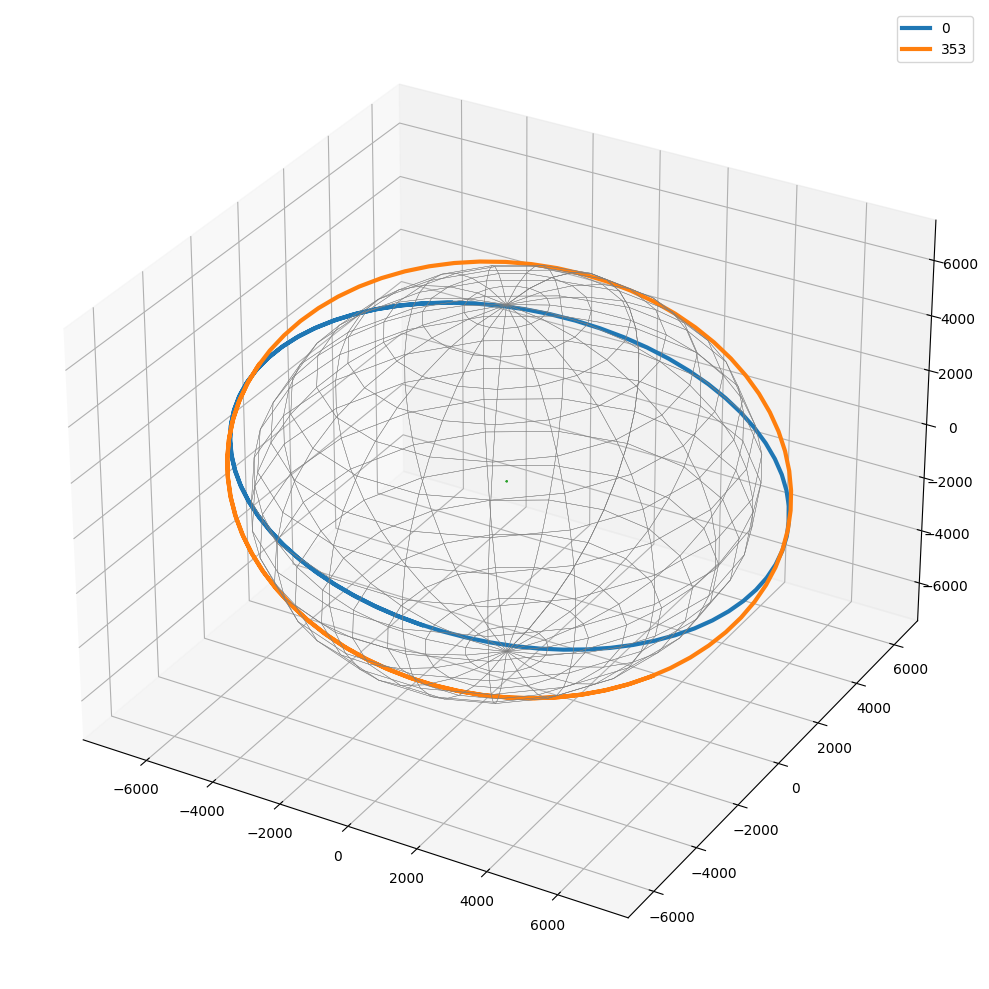

In [ ]:
"""# RASAT"""

# Load TLE data
RASAT_sats, RASAT_dict, RASAT_firsts, RASAT_seconds = satellite_from_txt("/content/sat000054277.txt")  # Update with the correct file path


"""# Plot in 3D"""

Time(satellite.jdsatepoch, format = 'jd')

def plot_trajectory3d(satellite, data_num = '0'):
    jd = satellite.jdsatepoch
    coordinates = []
    for time in np.linspace(jd, jd + .1, 100):
        _, r, v = satellite.sgp4(time, 0.0)
        r1, v1 = TEME_to_ITRF(time, np.array(r), np.array(v)*24*60*60)
        now = Time(time, format = 'jd')

        itrs = coord.ITRS(r1[0]*units.km, r1[1]*units.km, r1[2]*units.km, v1[0]*units.km/units.s, v1[1]*units.km/units.s, v1[2]*units.km/units.s, obstime=now)
        gcrs = itrs.transform_to(coord.GCRS(obstime=now))
        r, v = gcrs.cartesian.xyz.value,gcrs.velocity.d_xyz.value
        coordinates.append(r)
    coordinates = np.array(coordinates)
    ax.plot3D(coordinates[:,0], coordinates[:,1], coordinates[:,2], label=data_num, linewidth=3)
    plt.legend()

    # earth
    u = np.linspace(0, np.pi, 20)
    v = np.linspace(0, 2 * np.pi, 20)
    x = np.outer(np.sin(u), np.sin(v))
    y = np.outer(np.sin(u), np.cos(v))
    z = np.outer(np.cos(u), np.ones_like(v))
    R = 6371
    ax.plot_wireframe(R*x, R*y, R*z, color = 'gray', linewidth=.3)
    plt.tight_layout()

fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')
for index in np.linspace(0, len(RASAT_sats) - 1, 2).astype(int): # Changed the range of indices
    #plot_trajectory3d(GOKTURK_2_sats[index], str(index))
    plot_trajectory3d(RASAT_sats[index], str(index))

"""# FFT"""

y = np.array(RASAT_dict['Eccentricity'])
x = np.array(RASAT_dict['Julian Date of Epoch'])
sp = np.fft.fft(y-np.mean(y))
freq = np.fft.fftfreq(x.shape[-1])
plt.plot(freq, sp.real)

"""# Data Fitting"""










In [ ]:
# Prepare data for training
import pandas as pd # Import the pandas library
features = pd.DataFrame(RASAT_dict)
target = features.pop('Mean motion')

# ... rest of the code

In [ ]:
# Prepare data for training
import pandas as pd
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

features = pd.DataFrame(RASAT_dict)
target = features.pop('Mean motion')

# Scale the data
scaler = MinMaxScaler() # Now you can use MinMaxScaler
features_scaled = scaler.fit_transform(features)

# ... rest of your code

Epoch 1/1000
8/8 [==============================] - 1s 33ms/step - loss: 0.0171 - val_loss: 0.0078
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0065 - val_loss: 9.9570e-04
Epoch 3/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0043 - val_loss: 5.9966e-04
Epoch 4/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 5.8079e-06
Epoch 5/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 1.2471e-04
Epoch 6/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 4.8267e-04
Epoch 7/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 3.2069e-04
Epoch 8/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 6.1984e-04
Epoch 9/1000
8/8 [==============================] - 0s 7ms/step - loss: 9.2585e-04 - val_loss: 7.8271e-04
Epoch 10/1000
8/8 [==============================] - 0s 7ms/step - loss: 8.2712e

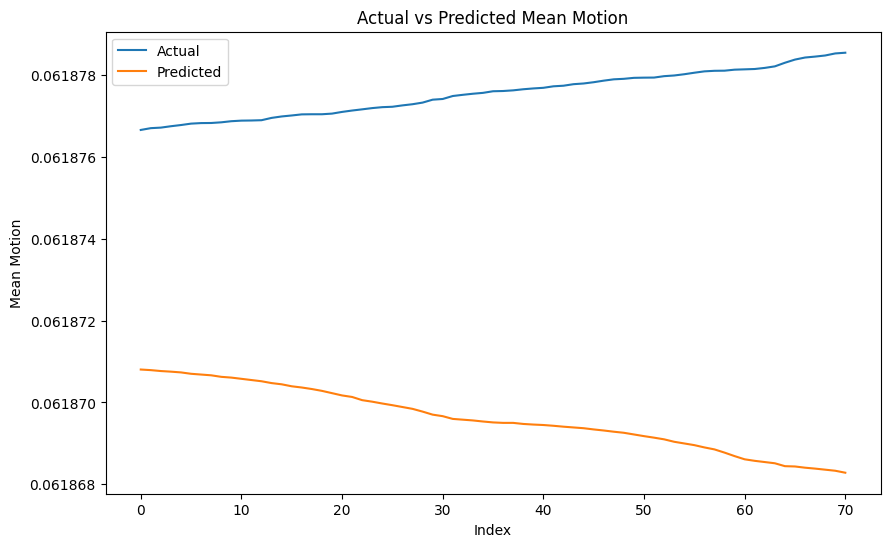

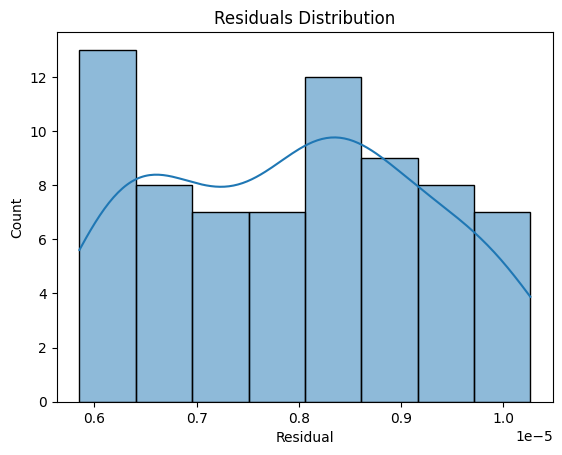

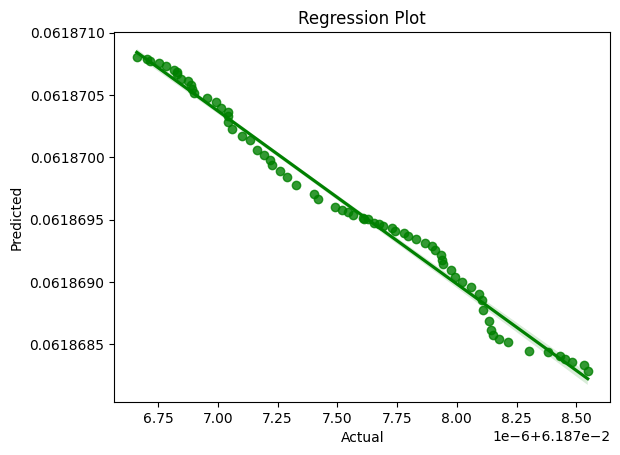

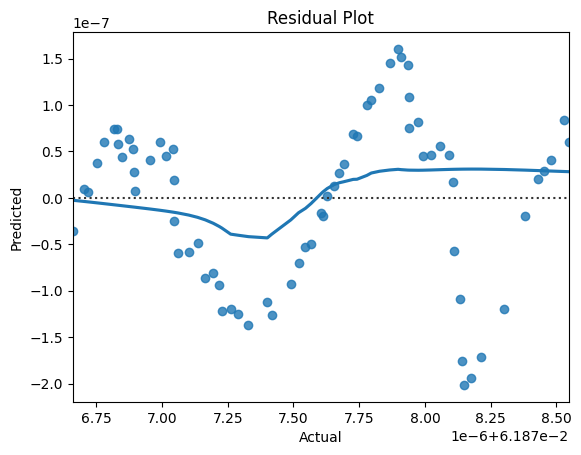

In [ ]:
# Prepare data for training
features = pd.DataFrame(RASAT_dict)
target = features.pop('Mean motion')

# Scale the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
train_size = int(len(features_scaled) * 0.8)
X_train, X_test = features_scaled[:train_size], features_scaled[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Build the neural network model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Mean Motion')
plt.legend()
plt.title('Actual vs Predicted Mean Motion')
plt.show()

# Plot residuals
residuals = y_test.values - y_pred.squeeze()
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.show()

# Regression plot
df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred.squeeze()})
sns.regplot(data=df, x='Actual', y='Predicted', color='g')
plt.title('Regression Plot')
plt.show()

# Residual plot
sns.residplot(data=df, x='Actual', y='Predicted', lowess=True)
plt.title('Residual Plot')
plt.show()